# Classifying a set of tweets into real PM's ones and fake ones

1. Data preparation
2. Exploratory data analysis
3. Separating Japanese sentences into words
4. Splitting data into training(70%) and testing(30%) dataset
5. Model selection by cross-validation
6. Evaluating model performance for testing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import MeCab
import re
import random

from urllib import request
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

%matplotlib inline

/home/da1sc0sg/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1. Data preparation

In [2]:
#read and decompose tweets
def tw_list_from_text(filepath):
    f = open(filepath)
    text = f.read()
    f.close()
    return text.split('\n')

#tweets from real PM
realPM_list = tw_list_from_text('./realPM_AbeShinzo.txt')
#tweets from fake PM
fakePM_list = tw_list_from_text('./fakePM_prime_fake.txt')

print("realPM: {0} tweets, last: {1}".format(len(realPM_list), realPM_list[0]))
print("fakePM: {0} tweets, last: {1}".format(len(fakePM_list), fakePM_list[0]))

realPM: 1333 tweets, last: 昨日、G7サミットが閉幕しました。 安倍総理と各国首脳の白熱した議論の様子を、1分の動画にまとめました。 是非ご覧ください。 (官邸FBより) https://t.co/CugcuXHfbx Sun Jun 10 11:19:05 +0000 2018
fakePM: 3276 tweets, last: 日本では「待機児童」が大問題になっています。しかし、世界のどこの国に、0歳児から保育所に預けて、働き続ける国があるのか。この点から考えていく必要がありそうです。 Fri Jun 15 12:03:15 +0000 2018


In [3]:
# concatenate all of tweets data into a dataframe
df = pd.DataFrame({'id': 'realPM' , 'body' : realPM_list})
df = df.append(pd.DataFrame({'id': 'fakePM', 'body': fakePM_list}), ignore_index=True)
df = df.iloc[0:len(df.index)-1]
df.shape

(4608, 2)

In [4]:
# check the number of tweets in each id
print(df.id.value_counts())
print(1.0*(df.id.value_counts()[1])/(df.id.value_counts()[0] + (df.id.value_counts()[1])))

fakePM    3275
realPM    1333
Name: id, dtype: int64
0.289279513889


Check contents

In [5]:
df.head()

,body,id
0,昨日、G7サミットが閉幕しました。 安倍総理と各国首脳の白熱した議論の様子を、1分の動画にま...,realPM
1,課題はあっても、自由で公正なルールに基づく貿易システムを発展させる中で解決を目指す。Ｇ７の一...,realPM
2,Ｇ７サミットが閉幕しました。 本年は貿易を巡り激しい意見のやりとりとなりました。しかし、会議...,realPM
3,官邸スタッフです。 安倍総理とトランプ大統領との日米首脳会談、その後の共同記者会見の様子をま...,realPM
4,RT @realDonaldTrump: Great day of meetings wit...,realPM


In [6]:
df.tail()

,body,id
4603,不況が深刻化している経済情勢も、来週は山場となりそうです。今は「嵐の前の静けさ」としか言いよ...,fakePM
4604,高齢者には年金があり、さらに給付金も支給し、盤石の態勢を取ります。とはいえ、若年層の反発は必...,fakePM
4605,たとえ若年層が全員、投票所に行ったとしても、勝てない現実があります。ここで意味が出てくるのが...,fakePM
4606,首相が保育所に関する発言で、追及されています。若年層に対する「子育て支援」や「少子化対策」は...,fakePM
4607,EU離脱をする場合、日本企業にも影響が出ます。EUの税制優遇を受けつつEU広域で事業を進める...,fakePM


In [7]:
df.body[0]

'昨日、G7サミットが閉幕しました。 安倍総理と各国首脳の白熱した議論の様子を、1分の動画にまとめました。 是非ご覧ください。 (官邸FBより) https://t.co/CugcuXHfbx Sun Jun 10 11:19:05 +0000 2018'

Create columns, a length of tweet and retweet flag.

In [8]:
# split body of each tweet into content and date information
df['date_info'] = [line[-31:] for line in df['body']]
df['tweet'] = [line[:len(line)-31] for line in df['body']]
# remove original body of tweets
df = df.iloc[:, df.columns != 'body']
# add column containing information of a length of tweet 
df['tweet_length'] = [ len(tw) for tw in df['tweet'] ]
# add column showing if a tweet is Retweet or not 
df['RT_flag'] = [s[0:2] == 'RT' for s in df['tweet']]

df.head()

,id,date_info,tweet,tweet_length,RT_flag
0,realPM,Sun Jun 10 11:19:05 +0000 2018,昨日、G7サミットが閉幕しました。 安倍総理と各国首脳の白熱した議論の様子を、1分の動画にま...,95,False
1,realPM,Sun Jun 10 02:17:00 +0000 2018,課題はあっても、自由で公正なルールに基づく貿易システムを発展させる中で解決を目指す。Ｇ７の一...,87,False
2,realPM,Sun Jun 10 02:16:52 +0000 2018,Ｇ７サミットが閉幕しました。 本年は貿易を巡り激しい意見のやりとりとなりました。しかし、会議...,126,False
3,realPM,Fri Jun 08 04:02:28 +0000 2018,官邸スタッフです。 安倍総理とトランプ大統領との日米首脳会談、その後の共同記者会見の様子をま...,95,False
4,realPM,Fri Jun 08 04:00:08 +0000 2018,RT @realDonaldTrump: Great day of meetings wit...,107,True


In [9]:
df.tail()

,id,date_info,tweet,tweet_length,RT_flag
4603,fakePM,Fri Mar 11 20:31:37 +0000 2016,不況が深刻化している経済情勢も、来週は山場となりそうです。今は「嵐の前の静けさ」としか言いよ...,54,False
4604,fakePM,Fri Mar 11 20:29:55 +0000 2016,高齢者には年金があり、さらに給付金も支給し、盤石の態勢を取ります。とはいえ、若年層の反発は必...,66,False
4605,fakePM,Fri Mar 11 20:28:05 +0000 2016,たとえ若年層が全員、投票所に行ったとしても、勝てない現実があります。ここで意味が出てくるのが...,58,False
4606,fakePM,Fri Mar 11 20:26:45 +0000 2016,首相が保育所に関する発言で、追及されています。若年層に対する「子育て支援」や「少子化対策」は...,65,False
4607,fakePM,Wed Mar 09 22:18:46 +0000 2016,EU離脱をする場合、日本企業にも影響が出ます。EUの税制優遇を受けつつEU広域で事業を進める...,66,False


# 2. Exploratory data analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f70b9f12080>]], dtype=object)

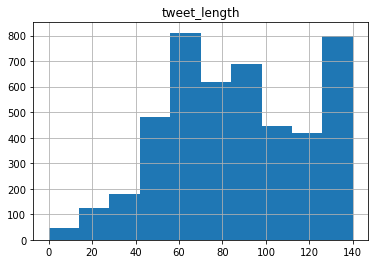

In [10]:
# check distribution of a length of tweets
df.hist(column='tweet_length')

There are two peaks of the number of characters in each tweet, around 60 characters and 140 characters.
(In Japanese, upper limit of the number of characters is 140 given Twitter's specification.)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f70b69976a0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f70b67c1a58>]], dtype=object)

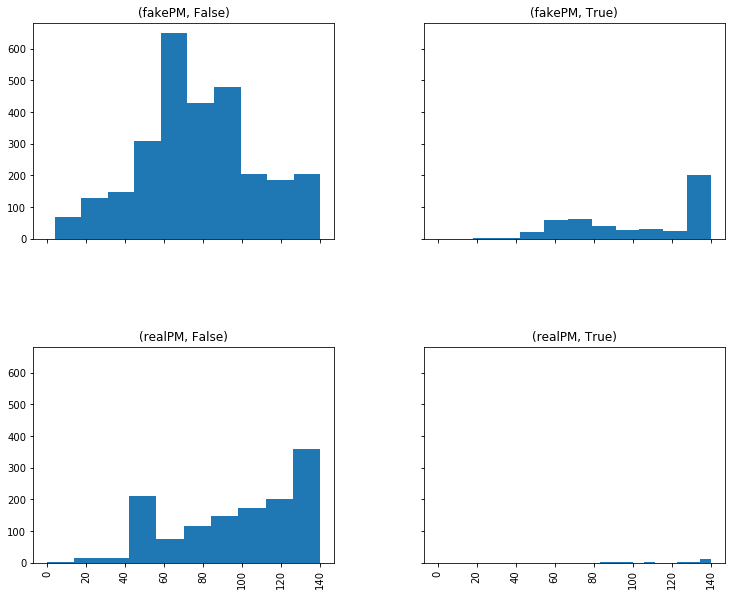

In [11]:
# check distribution of a length of tweets by user and RT
df.hist(column='tweet_length', by=['id', 'RT_flag'], figsize=(12,10), sharex=True, sharey=True)

- realPM tends to tweet near upper limit to the number of characters that a user can tweet compared to fakePM does.

- fakePM does more retweet than realPM.

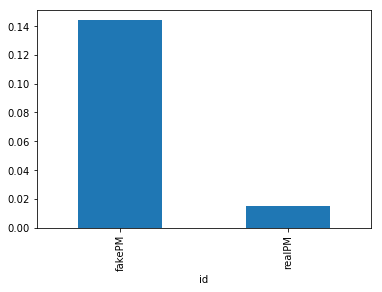

In [12]:
# create dataframe to compute the rate of retweet
df_RTtrate = pd.DataFrame()
df_RTtrate['tweet_count'] = df.groupby('id')['tweet'].count()
df_RTtrate['RT_count'] = df.groupby('id')['RT_flag'].sum()
df_RTtrate['RT_rate'] = df_RTtrate['RT_count'] / df_RTtrate['tweet_count']
df_RTtrate['RT_rate'].plot(kind='bar')

The retweet rate of fakePM is more than 14% while that of realPM is less than 2%.

# 3. Separating Japanese sentences into words

Here, I will demonstrate how MeCab works to separate Japanese words.

In [13]:
X = df['tweet']
print(X.head())

y = df['id']
print(y.head())

0    昨日、G7サミットが閉幕しました。 安倍総理と各国首脳の白熱した議論の様子を、1分の動画にま...
1    課題はあっても、自由で公正なルールに基づく貿易システムを発展させる中で解決を目指す。Ｇ７の一...
2    Ｇ７サミットが閉幕しました。 本年は貿易を巡り激しい意見のやりとりとなりました。しかし、会議...
3    官邸スタッフです。 安倍総理とトランプ大統領との日米首脳会談、その後の共同記者会見の様子をま...
4    RT @realDonaldTrump: Great day of meetings wit...
Name: tweet, dtype: object
0    realPM
1    realPM
2    realPM
3    realPM
4    realPM
Name: id, dtype: object


In [14]:
# use Mecab with mecab-ipadic-NEologd
tagger = MeCab.Tagger('-Ochasen -d /usr/lib/mecab/dic/mecab-ipadic-neologd')

In [15]:
# show example output of word separating by MeCab
parsed_ex_list = tagger.parse(re.sub('https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', ' ', X[40]))
parsed_ex_df = pd.DataFrame( [line.replace('\t', ',').split(',') for line in parsed_ex_list.split('\n')] )
parsed_ex_df

,0,1,2,3,4,5
0,伊勢神宮,イセジングウ,伊勢神宮,名詞-固有名詞-一般,,
1,にて,ニテ,にて,助詞-格助詞-一般,,
2,年頭,ネントウ,年頭,名詞-一般,,
3,の,ノ,の,助詞-連体化,,
4,記者会見,キシャカイケン,記者会見,名詞-固有名詞-一般,,
5,に,ニ,に,助詞-格助詞-一般,,
6,臨み,ノゾミ,臨む,動詞-自立,五段・マ行,連用形
7,まし,マシ,ます,助動詞,特殊・マス,連用形
8,た,タ,た,助動詞,特殊・タ,基本形
9,。,。,。,記号-句点,,


Thus, MeCab can split Japanese sentences into words.

Create stopwords list

In [16]:
# remove both Japanese and English stopwords from a tweet because some of tweets include English text
response = request.urlopen('http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt')
stopwords = [line.decode('utf-8').strip() for line in response]
response = request.urlopen('http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/English.txt')
stopwords += [line.decode('utf-8').strip() for line in response]
stopwords += ['RT', 'AbeShinzo', 'Prime_fake'] #remove words "RT" and Twitter account names

Extract word vector features by Morphological Analysis

In [17]:
# create list of words
def create_wordlist(_content, _tagger=tagger):
    # parse whole tweets while removing URL characters from a tweet because URL information is not useful for the classification
    parsed = _tagger.parse(re.sub('https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', ' ', _content))
    # split tweet by line feed code
    word_list = parsed.split('\n')
    # extract noun from each tweet
    #word_list = [s for s in word_list if re.match('.*\t.*\t.*\t名詞', s)]
    word_list = [line.split('\t')[0] for line in word_list]
    # remove stopwords
    word_list = [word for word in word_list[:-2] if word not in stopwords]
    # remove nouns which only contain figures(e.g. 2018)
    word_list = [word for word in word_list[:-2] if not word.isnumeric()]
    return word_list

# test output of the function
print(create_wordlist(X[1], tagger))
print(create_wordlist(X[2], tagger))

['課題', 'は', 'あっ', 'て', 'も', '、', '自由', 'で', '公正', 'な', 'ルール', 'に', '基づく', '貿易', 'システム', 'を', '発展', 'さ', 'せる', 'で', '解決', 'を', '目指す', '。', 'Ｇ７', 'の', '一致', 'し', 'た', '意志', 'を', '示す', 'が', 'でき']
['Ｇ７', 'サミット', 'が', '閉幕', 'し', 'た', '。', '本年', 'は', '貿易', 'を', '巡り', '激しい', '意見', 'の', 'やりとり', 'と', 'なり', 'た', '。', 'しかし', '、', '会議', 'の', 'に', '出て', 'も', '、', '昨日', 'は', '夜遅く', 'まで', '、', '本日', 'も', '朝', '早くから', '、', '首脳', '同士', 'が', '、', '直接', '、', '膝詰め', 'で', '議論', 'を', '重ね', '、', '合意', 'に', '達し']


In [18]:
#create CountVectorizer object
cvec = CountVectorizer(analyzer=create_wordlist, stop_words=stopwords)
# create word set of the tweets
cvec.fit(X)
# store names of word vectors
c_terms = cvec.get_feature_names()

In [19]:
# create a document-term matrix from all of the training data
X_dtm = cvec.fit_transform(X)
X_dtm.shape

(4608, 15737)

In [20]:
# check features that were created
print(len(cvec.get_feature_names()))
print(random.sample(cvec.get_feature_names(), 50))

15737
['新興国', '最悪', 'ルノー', 'ヤンゴン', 'なんとか', 'あさと', '証言内容', 'ウケ', '離せ', '次世代', '紅葉', '亭', '東松島市', '方々', '平和', '緊急支援', '益城町', '新大阪', '写真展', 'ありか', 'd(^_^o)', 'domestic', 'パワハラ', '中南米', '命運', '真相', '果たして', '撃', '面倒臭い', '於い', '集団心理', '並べ', '介護福祉士', 'クイズ', '献身', '武見敬三', '•', '午前６時', '鹿児島県', '預ける', '引っ張り', '（@', '地球市民', '飲ま', '豊田スタジアム', '昭恵夫人', '生かす', '詣り', '武蔵野市', '手厳しい']


Next, model selection and evaluation are conducted.

# 4. Splitting data into training(70%) and testing(30%) dataset

In [21]:
print(X.shape)
print(X.head())
print()
print(y.shape)
print(y.head())

(4608,)
0    昨日、G7サミットが閉幕しました。 安倍総理と各国首脳の白熱した議論の様子を、1分の動画にま...
1    課題はあっても、自由で公正なルールに基づく貿易システムを発展させる中で解決を目指す。Ｇ７の一...
2    Ｇ７サミットが閉幕しました。 本年は貿易を巡り激しい意見のやりとりとなりました。しかし、会議...
3    官邸スタッフです。 安倍総理とトランプ大統領との日米首脳会談、その後の共同記者会見の様子をま...
4    RT @realDonaldTrump: Great day of meetings wit...
Name: tweet, dtype: object

(4608,)
0    realPM
1    realPM
2    realPM
3    realPM
4    realPM
Name: id, dtype: object


In [22]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.9, random_state=1021)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print()
print(y_train.value_counts())
print(y_test.value_counts())
print()
#check positive/negative ratio in Target
print(1.0*(y_train.value_counts()[1])/(y_train.value_counts()[0] + y_train.value_counts()[1]))
print(1.0*(y_test.value_counts()[1])/(y_test.value_counts()[0] + y_test.value_counts()[1]))

(460,)
(4148,)
(460,)
(4148,)

fakePM    327
realPM    133
Name: id, dtype: int64
fakePM    2948
realPM    1200
Name: id, dtype: int64

0.289130434783
0.289296046287


In [24]:
rf = RandomForestClassifier(random_state=1021) 
rf.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

# 5. Model selection by cross-validation

To do proper cross-validation, feature creation (via CountVectorizer) should be executed withing each fold of cross-validation.

In [25]:
# define '1' as a missing value and impute a replacement using the median
imp = Imputer(missing_values=1, strategy='median')

In [26]:
cvec = CountVectorizer(analyzer=create_wordlist, stop_words=stopwords)
cvec

CountVectorizer(analyzer=<function create_wordlist at 0x7f70b65c1d90>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=['あそこ', 'あたり', 'あちら', 'あっち', 'あと', 'あな', 'あなた', 'あれ', 'いくつ', 'いつ', 'いま', 'いや', 'いろいろ', 'うち', 'おおまか', 'おまえ', 'おれ', 'がい', 'かく', 'かたち', 'かやの', 'から', 'がら', 'きた', 'くせ', 'ここ', 'こっち', 'こと', 'ごと', 'こちら', 'ごっちゃ', 'これ', 'これら', 'ごろ', 'さまざま', 'さらい', 'さん', 'しかた', 'しよう', 'すか', 'ずつ', 'すね', 'すべて', 'ぜんぶ',..."you're", 'yours', 'yourself', 'yourselves', "you've", 'z', 'zero', 'RT', 'AbeShinzo', 'Prime_fake'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [27]:
# create pipeline
rf = RandomForestClassifier(random_state=1021)
pipe = Pipeline([('CountVectorizer', cvec), ('Imputer', imp), ('Classifier', rf)])

In [28]:
# Create search space for GridSearchCV
params_cv = {
    'Classifier__n_estimators': [200, 400, 600, 800, 1000],
    'Classifier__max_features': ['sqrt'],
    'Classifier__max_depth': [10, 50, None]
}

clf = GridSearchCV(estimator=pipe, param_grid=params_cv, scoring='roc_auc', cv=5, verbose=0)
clf.fit(X_train, y_train=='realPM')

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('CountVectorizer', CountVectorizer(analyzer=<function create_wordlist at 0x7f70b65c1d90>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), ...imators=10, n_jobs=1, oob_score=False, random_state=1021,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'Classifier__n_estimators': [200, 400, 600, 800, 1000], 'Classifier__max_features': ['sqrt'], 'Classifier__max_depth': [10, 50, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [29]:
print('Best_estimator = {0}'.format(clf.best_estimator_.get_params()))

Best_estimator = {'steps': [('CountVectorizer', CountVectorizer(analyzer=<function create_wordlist at 0x7f70b65c1d90>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=['あそこ', 'あたり', 'あちら', 'あっち', 'あと', 'あな', 'あなた', 'あれ', 'いくつ', 'いつ', 'いま', 'いや', 'いろいろ', 'うち', 'おおまか', 'おまえ', 'おれ', 'がい', 'かく', 'かたち', 'かやの', 'から', 'がら', 'きた', 'くせ', 'ここ', 'こっち', 'こと', 'ごと', 'こちら', 'ごっちゃ', 'これ', 'これら', 'ごろ', 'さまざま', 'さらい', 'さん', 'しかた', 'しよう', 'すか', 'ずつ', 'すね', 'すべて', 'ぜんぶ',..."you're", 'yours', 'yourself', 'yourselves', "you've", 'z', 'zero', 'RT', 'AbeShinzo', 'Prime_fake'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('Imputer', Imputer(axis=0, copy=True, missing_values=1, strategy='median', verbose=0)), ('Classifier', RandomForestClassifier(bootstrap=True

In [30]:
clf.best_score_

0.86126473767778122

# 6. Evaluating model performance for testing data

In [31]:
# making predicttion for testing data by using the pipeline
y_pred_class = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)
y_pred_proba = y_pred_proba[:,1]

In [33]:
print('Test Accuracy:\t', metrics.accuracy_score(y_test=='realPM', y_pred_class))
fpr, tpr, threshold = metrics.roc_curve(y_test=='realPM', y_pred_proba)
print('Test AUC:\t', metrics.auc(fpr, tpr))

Test Accuracy:	 0.722757955641
Test AUC:	 0.862993130936


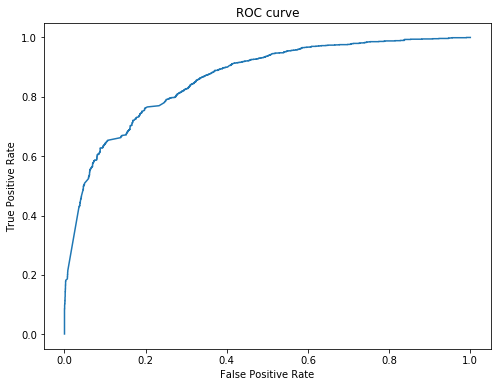

In [34]:
#plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()